In [94]:
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras import layers, Model
from tensorflow.keras import datasets

from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

# Data Load and Data Split

In [95]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("Train set shape:    ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test set shape:     ", x_test.shape)
print("Test labels shape:  ", y_test.shape)

Train set shape:     (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test set shape:      (10000, 32, 32, 3)
Test labels shape:   (10000, 1)


## before normalization

In [96]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## after normalization

In [97]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [98]:
latent_dim = 1024
image_shape = x_train[0].shape

In [99]:
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [100]:
class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.beta = beta

        # encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_1"),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_2"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_3"),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_4"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_5"),
            layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_6"),

            layers.Flatten(name="Encoder_Flatten"),
            # layers.Dense(512,  name="Encoder_Dense_1"),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar
    
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, Z_logvar, Z_mu):
        kl = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
        return self.beta * kl

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)

            reconstruction_loss = self.recon_loss(data, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [101]:
vae = VAE(latent_dim,  image_shape, 0.3)
vae.decoder.summary()

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_52 (Reshape)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_156            │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_157            │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_158            │ (None, 32, 32, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,254,659 (16.23 MB)

 Trainable params: 4,254,659 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
vae.encoder.summary()

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Conv2D_2 (Conv2D)       │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_4 (Conv2D)       │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_6 (Conv2D)       │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Flatten (Flatten)       │ (None, 2048)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

# print(history.history)

Epoch 1/50
 7/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - kl_loss: 1.5736e-04 - loss: 0.6926 - reconstruction_loss: 0.6925

W0000 00:00:1712695650.534720   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695650.535878   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - kl_loss: 6.2345e-04 - loss: 0.6878 - reconstruction_loss: 0.6870 - total_loss: 0.6748
Epoch 2/50
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0072 - loss: 0.6332 - reconstruction_loss: 0.6260

W0000 00:00:1712695655.218863   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695655.221765   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0081 - loss: 0.6278 - reconstruction_loss: 0.6196 - total_loss: 0.6245
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0107 - loss: 0.6192 - reconstruction_loss: 0.6085 - total_loss: 0.6179
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0124 - loss: 0.6141 - reconstruction_loss: 0.6016 - total_loss: 0.6132
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0130 - loss: 0.6121 - reconstruction_loss: 0.5990 - total_loss: 0.6114
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0136 - loss: 0.6108 - reconstruction_loss: 0.5972 - total_loss: 0.6102
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0139 - loss: 0.6099 - reconstruction_loss: 0.5959 - total_loss: 0.6090
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0141 - loss: 0.6073 - reconstruction_loss: 0.5932 - total_loss: 0.6072
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

In [104]:
num_images = 5

In [105]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Decode the latent vectors to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)

    return generated_images

# Generate images from random latent vectors
generated_images = generate_images_from_latent_vectors(vae, num_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


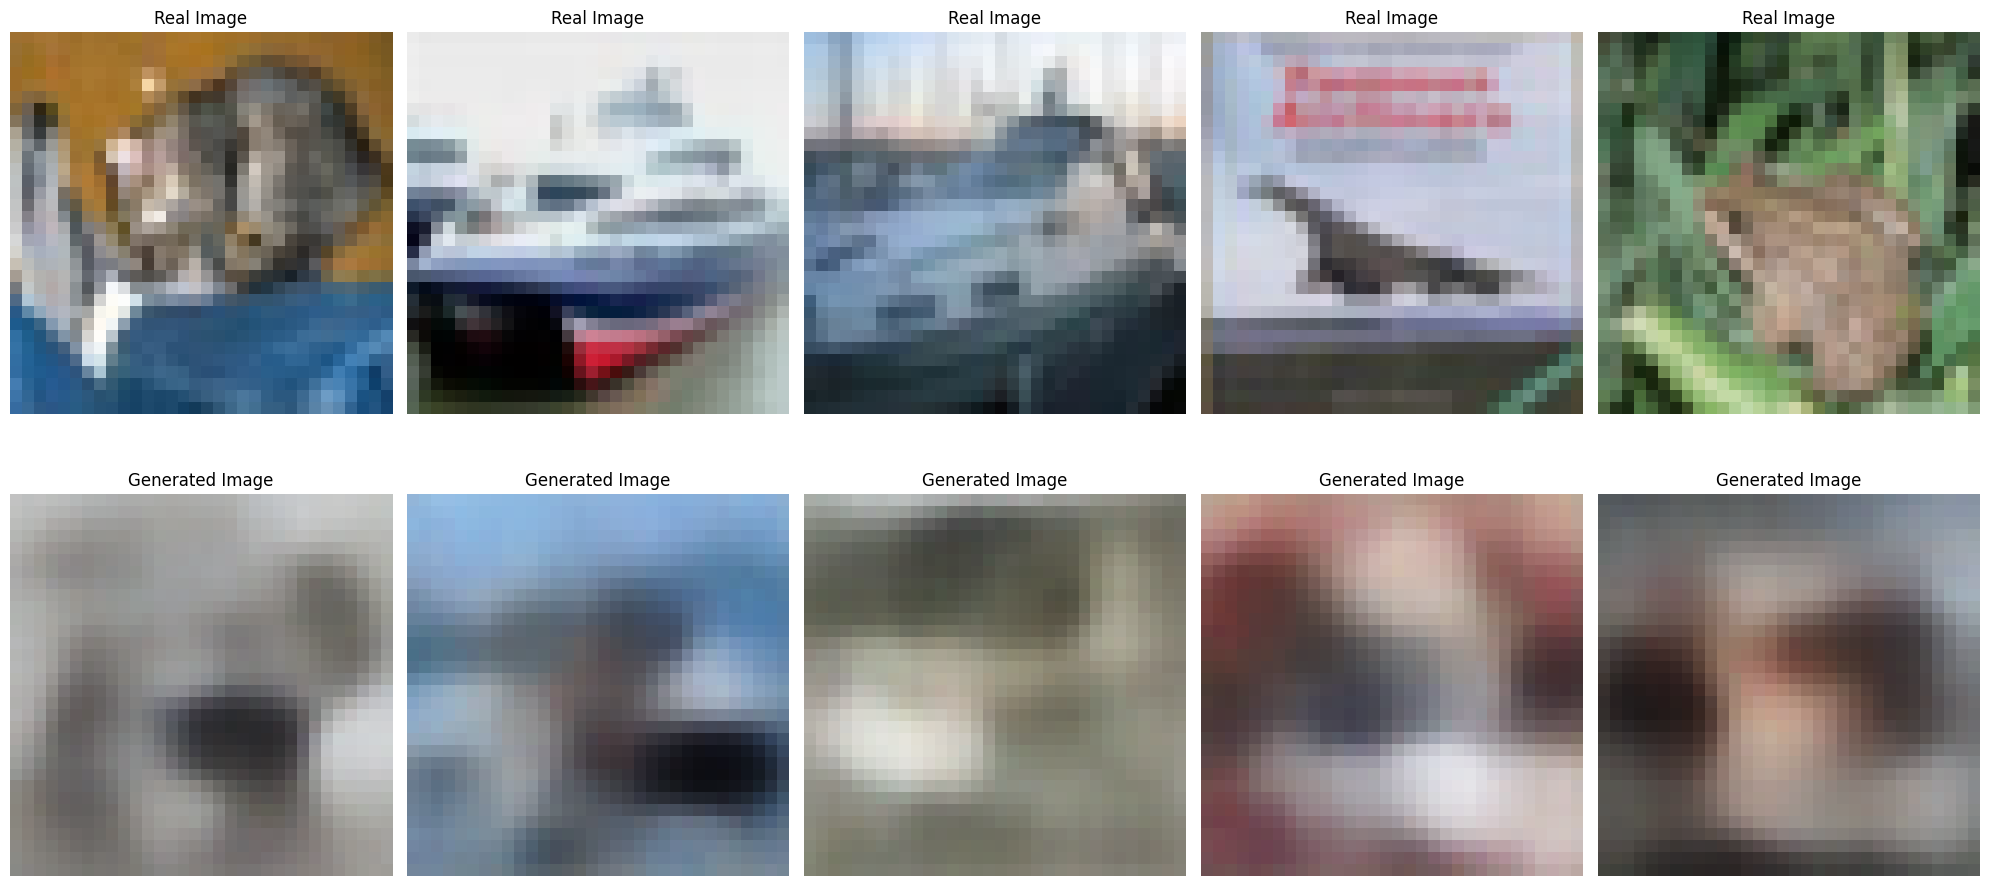

In [106]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20, 10))

    # Plot real images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i])
        plt.title('Real Image')
        plt.axis('off')

    # Plot generated images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
        plt.imshow(generated_images[i])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot real and generated images side by side vertically
plot_real_and_generated_images(x_test[:num_images], generated_images, num_images)


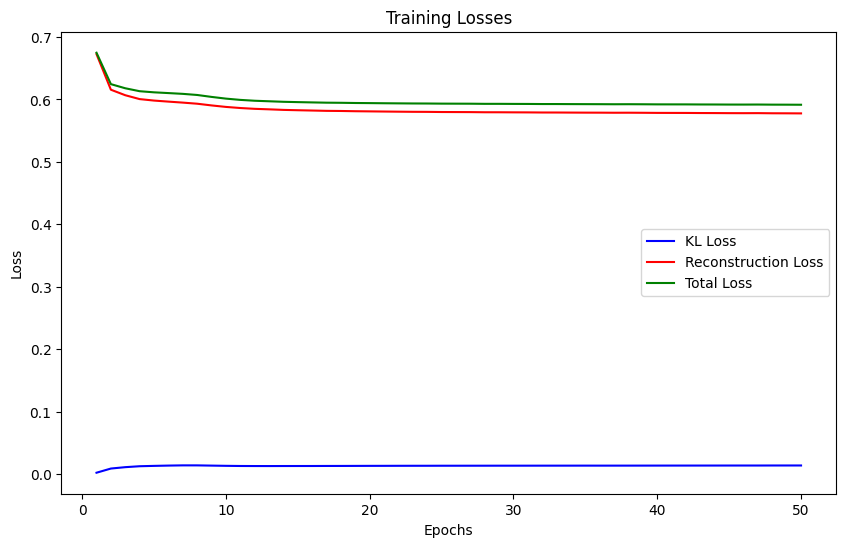

In [107]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['total_loss']

# Plot the losses
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [108]:
# Define list of beta values to try
beta_values = [0.0001, 0.001 ,0.01, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.3]

# Initialize lists to store losses and generated images
loss_histories = []
generated_images_list = []

# Iterate over each beta value
for beta in beta_values:
    print(f"Beta: {beta}")
    # Train the model
    vae1 = VAE(latent_dim, image_shape, beta)
    vae1.compile(optimizer=keras.optimizers.Adam())
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
    history = vae1.fit(x_train, epochs=40, batch_size=512, callbacks=[early_stopping], verbose=1)
    
    # Store training history for each loss
    loss_histories.append(history.history)
    
    # Generate images
    generated_images = generate_images_from_latent_vectors(vae1, num_images_to_generate)
    
    # Store generated images
    generated_images_list.append(generated_images)




Beta: 0.0001
Epoch 1/40
 6/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 1.0355e-07 - loss: 0.6923 - reconstruction_loss: 0.6923

W0000 00:00:1712695774.121780   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695774.122956   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - kl_loss: 2.8131e-05 - loss: 0.6739 - reconstruction_loss: 0.6737 - total_loss: 0.6571
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 8.8282e-05 - loss: 0.6356 - reconstruction_loss: 0.6355

W0000 00:00:1712695778.802307   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695778.805523   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 1.0544e-04 - loss: 0.6157 - reconstruction_loss: 0.6154 - total_loss: 0.6011
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 2.2037e-04 - loss: 0.5823 - reconstruction_loss: 0.5820 - total_loss: 0.5794
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 2.8235e-04 - loss: 0.5730 - reconstruction_loss: 0.5727 - total_loss: 0.5722
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 2.9976e-04 - loss: 0.5691 - reconstruction_loss: 0.5688 - total_loss: 0.5684
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 3.2236e-04 - loss: 0.5660 - reconstruction_loss: 0.5656 - total_loss: 0.5659
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 3.3588e-04 - loss: 0.5640 - reconstruction_loss: 0.5636 - total_loss: 0.5643
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 3.5167e-04 - loss: 0.5625 - reconstruction_loss: 0.5621 - total_loss: 0.5623
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 

W0000 00:00:1712695874.588588   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695874.589806   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 2.2793e-04 - loss: 0.6749 - reconstruction_loss: 0.6745 - total_loss: 0.6576
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 7.7986e-04 - loss: 0.6317 - reconstruction_loss: 0.6310

W0000 00:00:1712695879.329598   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695879.332748   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 7.6750e-04 - loss: 0.6153 - reconstruction_loss: 0.6144 - total_loss: 0.6027
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0013 - loss: 0.5862 - reconstruction_loss: 0.5848 - total_loss: 0.5827
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0016 - loss: 0.5753 - reconstruction_loss: 0.5737 - total_loss: 0.5745
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0017 - loss: 0.5719 - reconstruction_loss: 0.5702 - total_loss: 0.5715
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0018 - loss: 0.5691 - reconstruction_loss: 0.5674 - total_loss: 0.5685
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0017 - loss: 0.5689 - reconstruction_loss: 0.5671 - total_loss: 0.5676
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0018 - loss: 0.5650 - reconstruction_loss: 0.5632 - total_loss: 0.5648
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 

W0000 00:00:1712695974.550621   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695974.551756   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 7.5839e-04 - loss: 0.6781 - reconstruction_loss: 0.6772 - total_loss: 0.6619
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0022 - loss: 0.6271 - reconstruction_loss: 0.6249

W0000 00:00:1712695979.281367   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712695979.284366   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0024 - loss: 0.6108 - reconstruction_loss: 0.6084 - total_loss: 0.6026
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0032 - loss: 0.5937 - reconstruction_loss: 0.5904 - total_loss: 0.5891
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0038 - loss: 0.5829 - reconstruction_loss: 0.5790 - total_loss: 0.5818
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0040 - loss: 0.5797 - reconstruction_loss: 0.5757 - total_loss: 0.5787
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0041 - loss: 0.5773 - reconstruction_loss: 0.5731 - total_loss: 0.5766
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0042 - loss: 0.5741 - reconstruction_loss: 0.5698 - total_loss: 0.5740
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0042 - loss: 0.5736 - reconstruction_loss: 0.5694 - total_loss: 0.5725
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.00

W0000 00:00:1712696074.334103   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696074.335304   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 8.3737e-04 - loss: 0.6842 - reconstruction_loss: 0.6831 - total_loss: 0.6660
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0049 - loss: 0.6235 - reconstruction_loss: 0.6186

W0000 00:00:1712696079.053777   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696079.057154   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0057 - loss: 0.6175 - reconstruction_loss: 0.6118 - total_loss: 0.6136
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0079 - loss: 0.6052 - reconstruction_loss: 0.5973 - total_loss: 0.6031
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0091 - loss: 0.5988 - reconstruction_loss: 0.5896 - total_loss: 0.5984
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0097 - loss: 0.5975 - reconstruction_loss: 0.5877 - total_loss: 0.5963
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0100 - loss: 0.5941 - reconstruction_loss: 0.5841 - total_loss: 0.5936
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0099 - loss: 0.5914 - reconstruction_loss: 0.5815 - total_loss: 0.5908
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0095 - loss: 0.5887 - reconstruction_loss: 0.5792 - total_loss: 0.5885
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.00

W0000 00:00:1712696173.940338   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696173.941519   15446 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - kl_loss: 6.4613e-04 - loss: 0.6870 - reconstruction_loss: 0.6862 - total_loss: 0.6718
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0060 - loss: 0.6289 - reconstruction_loss: 0.6229

W0000 00:00:1712696178.624817   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696178.627804   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0070 - loss: 0.6239 - reconstruction_loss: 0.6168 - total_loss: 0.6206
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0095 - loss: 0.6144 - reconstruction_loss: 0.6049 - total_loss: 0.6133
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0110 - loss: 0.6095 - reconstruction_loss: 0.5985 - total_loss: 0.6086
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0117 - loss: 0.6063 - reconstruction_loss: 0.5945 - total_loss: 0.6057
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0122 - loss: 0.6048 - reconstruction_loss: 0.5925 - total_loss: 0.6044
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0124 - loss: 0.6031 - reconstruction_loss: 0.5907 - total_loss: 0.6024
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0123 - loss: 0.5998 - reconstruction_loss: 0.5875 - total_loss: 0.5994
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - kl_loss: 0.01

W0000 00:00:1712696273.745125   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696273.746314   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 4.9106e-04 - loss: 0.6898 - reconstruction_loss: 0.6892 - total_loss: 0.6810
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0074 - loss: 0.6393 - reconstruction_loss: 0.6319

W0000 00:00:1712696278.481719   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696278.484750   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0087 - loss: 0.6349 - reconstruction_loss: 0.6261 - total_loss: 0.6311
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0120 - loss: 0.6261 - reconstruction_loss: 0.6141 - total_loss: 0.6253
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0135 - loss: 0.6227 - reconstruction_loss: 0.6092 - total_loss: 0.6217
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0147 - loss: 0.6197 - reconstruction_loss: 0.6050 - total_loss: 0.6194
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0150 - loss: 0.6187 - reconstruction_loss: 0.6038 - total_loss: 0.6185
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0154 - loss: 0.6179 - reconstruction_loss: 0.6025 - total_loss: 0.6180
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0156 - loss: 0.6178 - reconstruction_loss: 0.6022 - total_loss: 0.6174
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.01

W0000 00:00:1712696373.320154   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696373.321475   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 6.1132e-04 - loss: 0.6886 - reconstruction_loss: 0.6879 - total_loss: 0.6777
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0085 - loss: 0.6431 - reconstruction_loss: 0.6346

W0000 00:00:1712696378.033674   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696378.036647   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0099 - loss: 0.6372 - reconstruction_loss: 0.6272 - total_loss: 0.6347
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0129 - loss: 0.6308 - reconstruction_loss: 0.6179 - total_loss: 0.6302
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0141 - loss: 0.6283 - reconstruction_loss: 0.6142 - total_loss: 0.6281
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0154 - loss: 0.6257 - reconstruction_loss: 0.6103 - total_loss: 0.6254
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0159 - loss: 0.6247 - reconstruction_loss: 0.6088 - total_loss: 0.6243
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0161 - loss: 0.6238 - reconstruction_loss: 0.6077 - total_loss: 0.6238
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0164 - loss: 0.6235 - reconstruction_loss: 0.6070 - total_loss: 0.6235
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1712696473.057935   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696473.059195   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - kl_loss: 2.8349e-04 - loss: 0.6906 - reconstruction_loss: 0.6902 - total_loss: 0.6857
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0075 - loss: 0.6506 - reconstruction_loss: 0.6431

W0000 00:00:1712696477.912846   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696477.915827   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0098 - loss: 0.6447 - reconstruction_loss: 0.6349 - total_loss: 0.6414
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0135 - loss: 0.6367 - reconstruction_loss: 0.6233 - total_loss: 0.6358
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0147 - loss: 0.6343 - reconstruction_loss: 0.6196 - total_loss: 0.6342
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0156 - loss: 0.6330 - reconstruction_loss: 0.6174 - total_loss: 0.6322
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0168 - loss: 0.6309 - reconstruction_loss: 0.6141 - total_loss: 0.6308
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0169 - loss: 0.6303 - reconstruction_loss: 0.6135 - total_loss: 0.6303
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0172 - loss: 0.6294 - reconstruction_loss: 0.6122 - total_loss: 0.6297
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.01

W0000 00:00:1712696573.370654   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696573.371769   15445 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 4.0435e-04 - loss: 0.6912 - reconstruction_loss: 0.6908 - total_loss: 0.6904
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 1.5260e-05 - loss: 0.6894 - reconstruction_loss: 0.6894

W0000 00:00:1712696578.087666   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696578.090989   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0021 - loss: 0.6825 - reconstruction_loss: 0.6803 - total_loss: 0.6693
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0122 - loss: 0.6452 - reconstruction_loss: 0.6330 - total_loss: 0.6441
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0145 - loss: 0.6423 - reconstruction_loss: 0.6278 - total_loss: 0.6417
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0155 - loss: 0.6410 - reconstruction_loss: 0.6255 - total_loss: 0.6407
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0158 - loss: 0.6405 - reconstruction_loss: 0.6248 - total_loss: 0.6402
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0168 - loss: 0.6390 - reconstruction_loss: 0.6222 - total_loss: 0.6387
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0174 - loss: 0.6382 - reconstruction_loss: 0.6208 - total_loss: 0.6379
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1712696674.382440   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696674.383622   15448 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - kl_loss: 9.6525e-05 - loss: 0.6909 - reconstruction_loss: 0.6908 - total_loss: 0.6904
Epoch 2/40
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - kl_loss: 3.0408e-04 - loss: 0.6892 - reconstruction_loss: 0.6889

W0000 00:00:1712696679.062089   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712696679.065209   15447 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0054 - loss: 0.6753 - reconstruction_loss: 0.6698 - total_loss: 0.6631
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0145 - loss: 0.6495 - reconstruction_loss: 0.6350 - total_loss: 0.6495
Epoch 4/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0158 - loss: 0.6485 - reconstruction_loss: 0.6327 - total_loss: 0.6482
Epoch 5/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0163 - loss: 0.6471 - reconstruction_loss: 0.6308 - total_loss: 0.6475
Epoch 6/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0164 - loss: 0.6477 - reconstruction_loss: 0.6312 - total_loss: 0.6472
Epoch 7/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0168 - loss: 0.6472 - reconstruction_loss: 0.6303 - total_loss: 0.6470
Epoch 8/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0171 - loss: 0.6468 - reconstruction_loss: 0.6297 - total_loss: 0.6467
Epoch 9/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

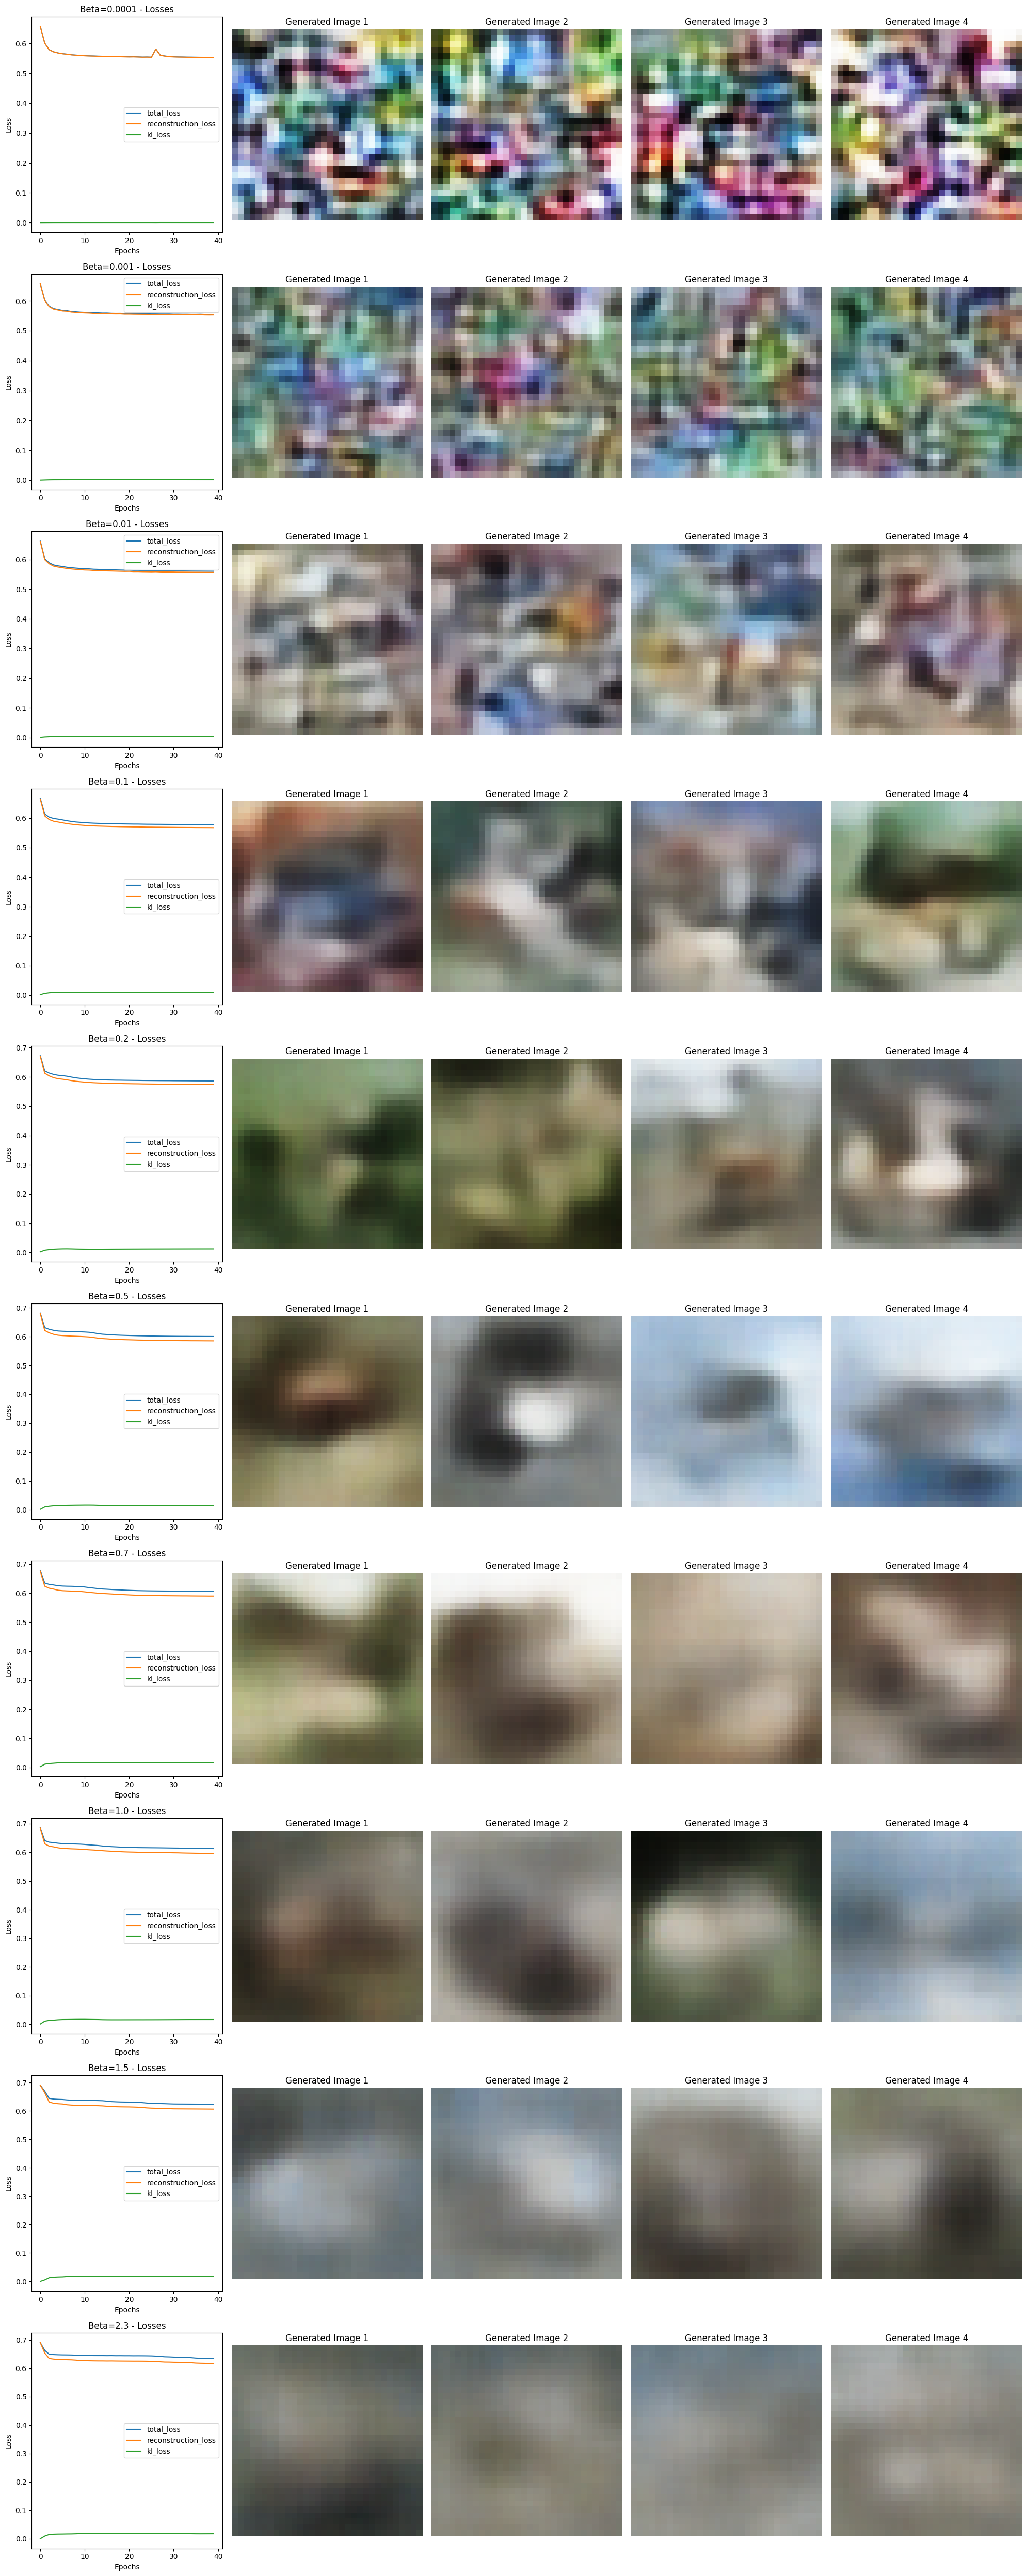

In [109]:
fig, axs = plt.subplots(len(beta_values), 5, figsize=(20, 5*len(beta_values)))  

for i, (beta, loss_history, generated_images) in enumerate(zip(beta_values, loss_histories, generated_images_list)):
    for j, loss_label in enumerate(loss_labels):
        axs[i, 0].plot(loss_history[loss_label], label=loss_label)
    axs[i, 0].set_title(f'Beta={beta} - Losses')
    axs[i, 0].set_ylabel('Loss')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].legend()

    # Plot generated images
    for j in range(4):
        axs[i, j+1].imshow(generated_images[j])
        axs[i, j+1].set_title(f'Generated Image {j+1}')
        axs[i, j+1].axis('off')

plt.tight_layout()
plt.show()


In [110]:
from tqdm import tqdm

def generate_latent_space(vae, n=20, scale=3):
    img_height = 32
    
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(n * n, latent_dim))

    generated_images = np.zeros((n * img_height, n * img_height, 3))

    for i, zi in enumerate(tqdm(np.linspace(-scale, scale, n), desc='Progress')):
        for j, zj in enumerate(np.linspace(-scale, scale, n)):
            z_sample = random_latent_vectors[i * n + j]
            # Suppress stdout temporarily
            with suppress_stdout():
                x_decoded = vae.decoder.predict(np.array([z_sample]))
            digit = x_decoded[0].reshape(img_height, img_height, 3)
            generated_images[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
                :,
            ] = digit

    return generated_images

# Suppress stdout context manager
from contextlib import contextmanager
import os, sys

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

latent_space = generate_latent_space(vae)


Progress: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


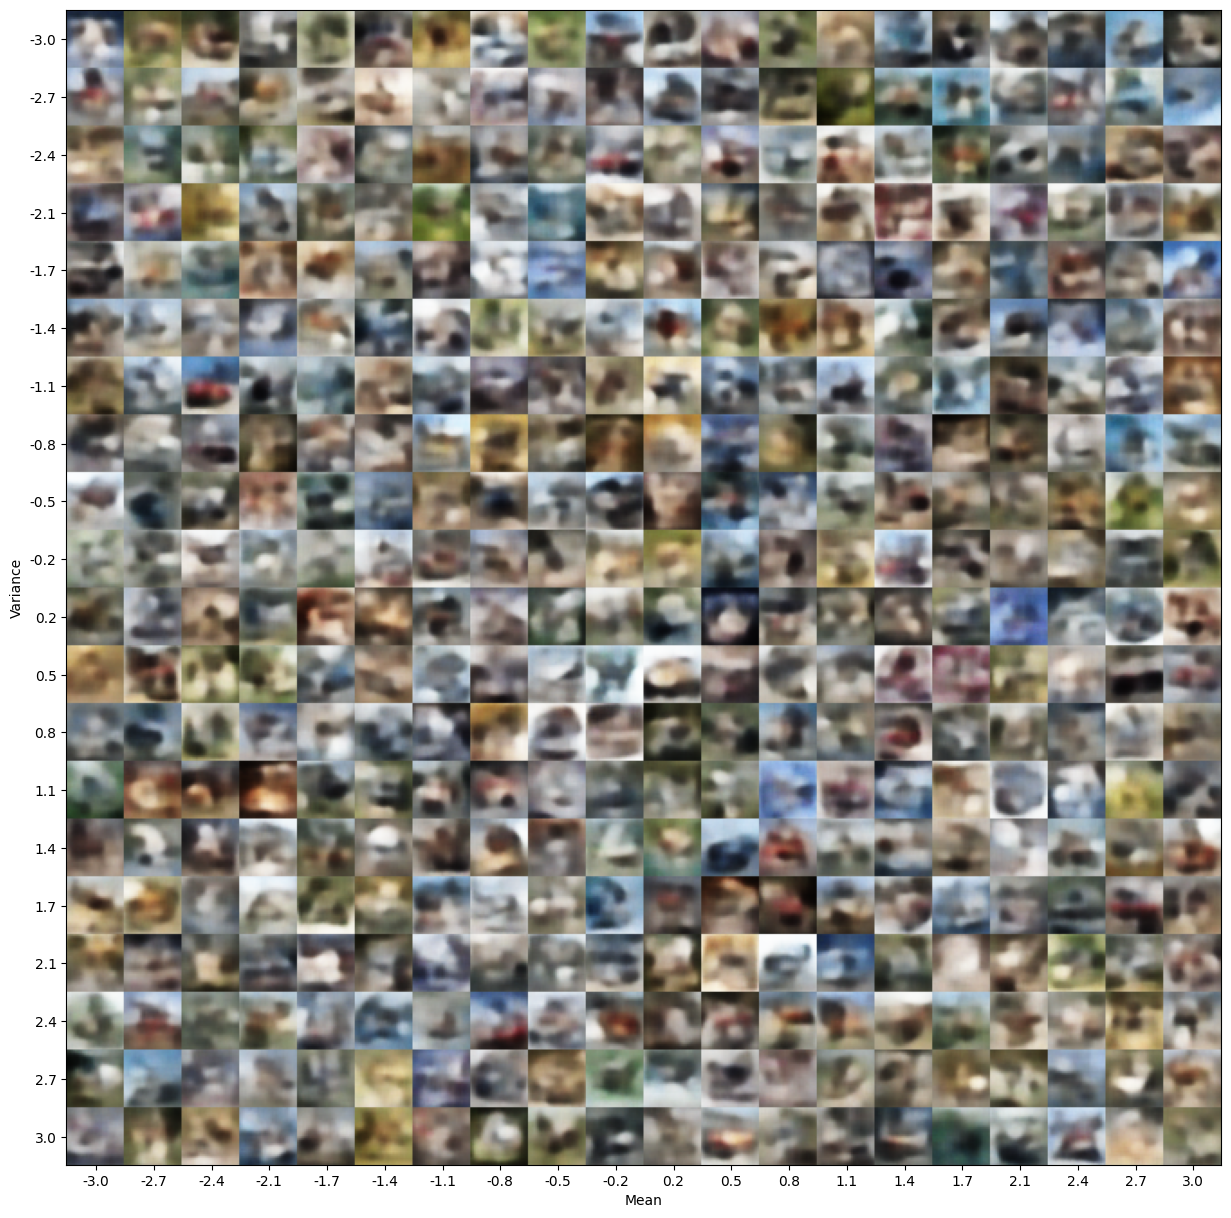

In [111]:
def plot_latent_space(generated_images, n=20, scale=3, figsize=15):
    img_height = generated_images.shape[0] // n
    
    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(np.linspace(-scale, scale, n), 1)
    sample_range_y = np.round(np.linspace(-scale, scale, n), 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.imshow(generated_images)
    plt.show()
    
plot_latent_space(latent_space)

In [112]:
generated_images = generate_images_from_latent_vectors(vae, 100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [113]:
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = [resize(image, new_shape, 0) for image in images]
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load pre-trained InceptionV3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Load your real and generated images (replace these with your actual images)
real_images = trainX[:100]  # Load your real images here

# Convert integer to floating point values
real_images = real_images.astype('float32')
generated_images = generated_images.astype('float32')

# Resize images to (299, 299, 3) as required by InceptionV3
real_images_resized = scale_images(real_images, (299, 299, 3))
generated_images_resized = scale_images(generated_images, (299, 299, 3))

# Preprocess images
real_images_preprocessed = preprocess_input(real_images_resized)
generated_images_preprocessed = preprocess_input(generated_images_resized)

# Calculate FID score between real and generated images
fid_score = calculate_fid(model, real_images_preprocessed, generated_images_preprocessed)
print('FID Score:', fid_score)


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
FID Score: 1.3895050708477943e+79
